# Random Descent vs Steepest Descent

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import extrenal librarires
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import our code
from heur_sg import ShootAndGo
from objfun_sumsin import SumSin

### Experiment setup

Runs selected objective function (`of`) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [3]:
def experiment(of, maxeval, num_runs, hmax, random_descent):
    method = 'RD' if random_descent else 'SD'
    results = []
    for i in tqdm(range(num_runs), 'Testing method={}, hmax={}'.format(method, hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}_{}'.format(method, hmax) # name of the heuristic
        result['method'] = method
        result['hmax'] = hmax
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'method', 'hmax', 'best_x', 'best_y', 'neval'])

In [4]:
NUM_RUNS = 10000  # set to ~1k for first experiments

# Obj. function dimensionality vs. complexity

We will be testing two instances of multimodal objective function:

$$\sum \mid \mathbf{x} \cdot \sin{\mathbf{x}} \mid$$

1-D demo:

<IPython.core.display.Javascript object>


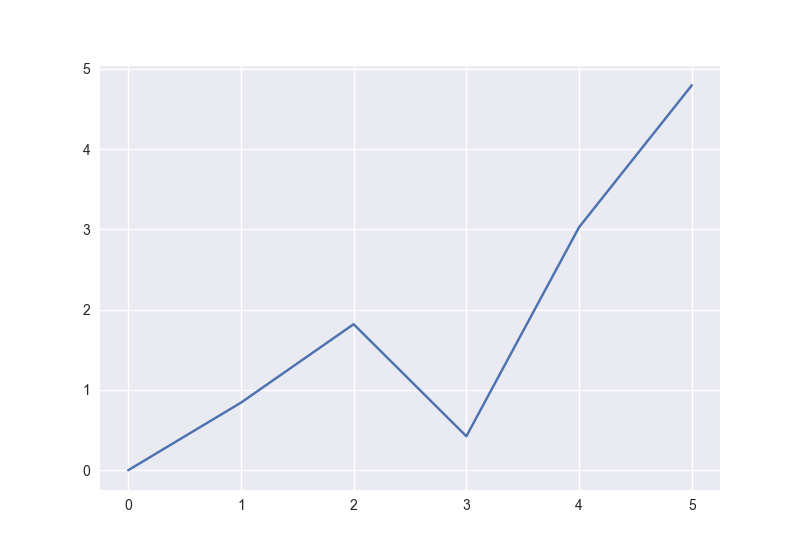

In [5]:
of_demo = SumSin([0], [5])
x = np.arange(6)
y = [of_demo.evaluate([x]) for x in np.arange(6)]
ax = plt.plot(x, y)

Instances (A, B) will differ by their dimension.

## A: 4-dimensional

#### Objective function setup

In [6]:
n_dim = 4
a = np.zeros((n_dim,), dtype=int)
b = 5*np.ones((n_dim,), dtype=int)
of_a = SumSin(a, b)
print(a, b)

[0 0 0 0] [5 5 5 5]


In [7]:
num_states = np.power(b[0]-a[0]+1, np.size(a))
num_states

1296

In [8]:
maxeval = int(num_states*0.10)  # 10% of state number
maxeval

129

#### Experiments

In [9]:
table = pd.DataFrame()

# STEEPEST DESCENT
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of=of_a, maxeval=maxeval, num_runs=NUM_RUNS, hmax=hmax, random_descent=False)
    res['of'] = 'A'
    table = pd.concat([table, res], axis=0)

In [10]:
# RANDOM DESCENT
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of=of_a, maxeval=maxeval, num_runs=NUM_RUNS, hmax=hmax, random_descent=True)
    res['of'] = 'A'
    table = pd.concat([table, res], axis=0)

## B: 5-dimensional

#### Objective function set up

In [11]:
n_dim = 5
a = np.zeros((n_dim,), dtype=int)
b = 5 * np.ones((n_dim,), dtype=int)
of_b = SumSin(a, b)
print(a, b)

[0 0 0 0 0] [5 5 5 5 5]


In [12]:
num_states = np.power(b[0] - a[0] + 1, np.size(a))
num_states

7776

In [13]:
maxeval = int(num_states * 0.1)  # 10% of state number
maxeval

777

#### Experiments

In [14]:
# STEEPEST DESCENT
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of=of_b, maxeval=maxeval, num_runs=NUM_RUNS, hmax=hmax, random_descent=False)
    res['of'] = 'B'
    table = pd.concat([table, res], axis=0)

In [15]:
# RANDOM DESCENT
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of=of_b, maxeval=maxeval, num_runs=NUM_RUNS, hmax=hmax, random_descent=True)
    res['of'] = 'B'
    table = pd.concat([table, res], axis=0)

In [16]:
# table preview
table.head()

,heur,run,method,hmax,best_x,best_y,neval,of
0,SG_SD_0,0,SD,0.0,"[0, 0, 1, 0]",0.841471,inf,A
1,SG_SD_0,1,SD,0.0,"[1, 3, 0, 3]",1.688191,inf,A
2,SG_SD_0,2,SD,0.0,"[0, 3, 0, 0]",0.423360,inf,A
3,SG_SD_0,3,SD,0.0,"[1, 0, 0, 0]",0.841471,inf,A
4,SG_SD_0,4,SD,0.0,"[0, 0, 0, 1]",0.841471,inf,A


## Results analysis

#### Solution quality

<IPython.core.display.Javascript object>


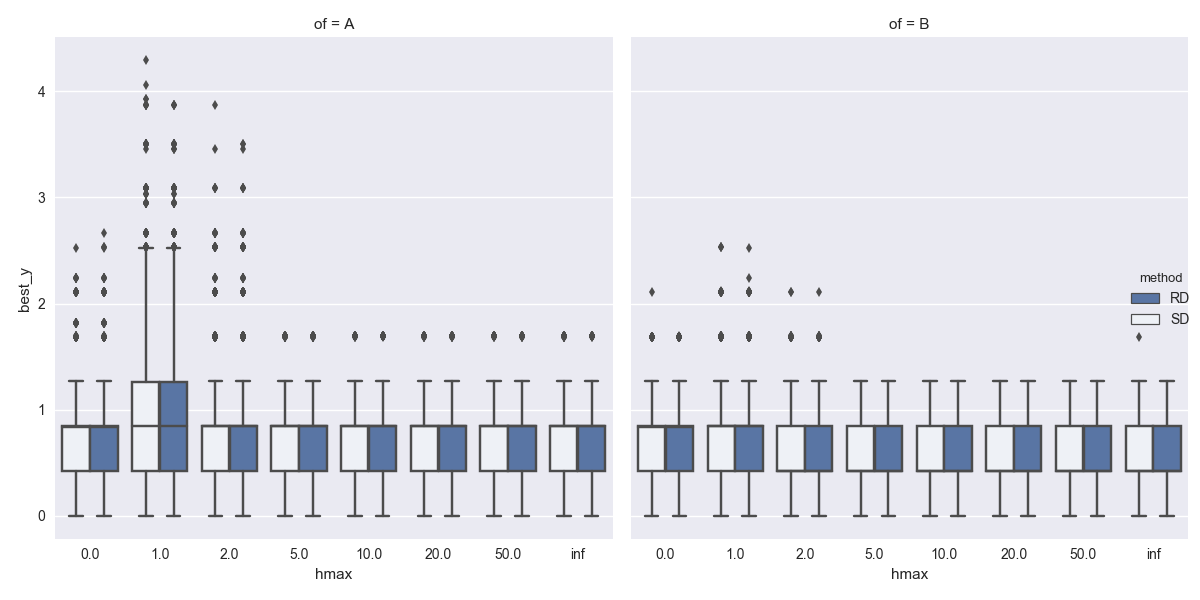

In [17]:
g = sns.FacetGrid(table, col='of', size=6)
ax = g.map(sns.boxplot, 'hmax', 'best_y', 'method').add_legend(title='method')

#### Number of evaluations

<IPython.core.display.Javascript object>


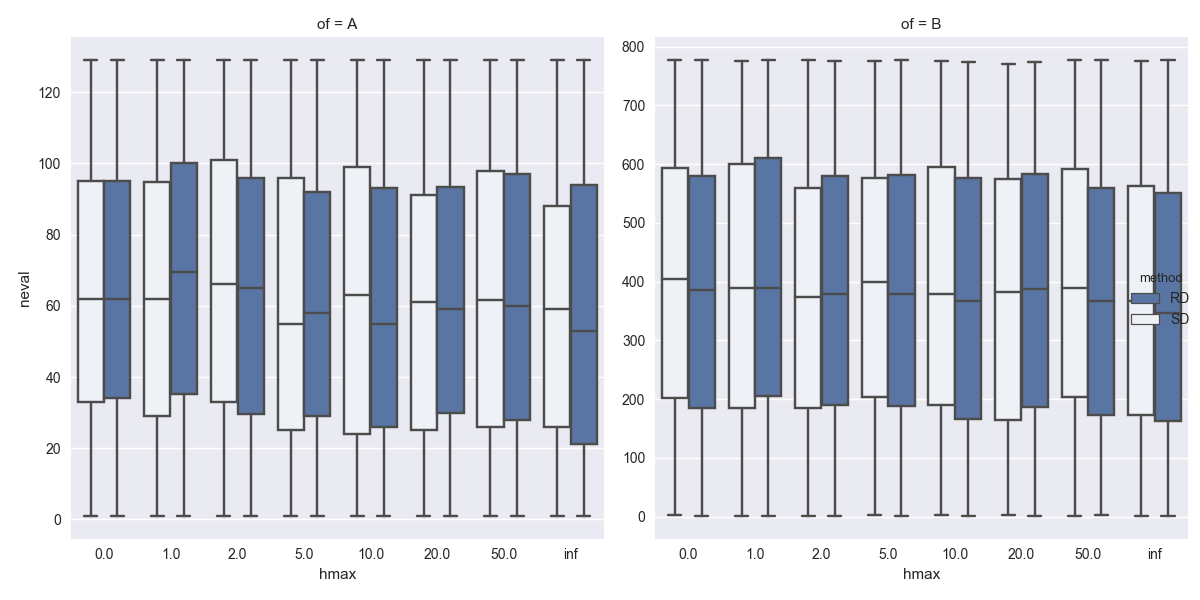

In [18]:
g = sns.FacetGrid(table[table['neval'] < np.inf], col='of', sharey=False, size=6)
ax = g.map(sns.boxplot, 'hmax', 'neval', 'method').add_legend(title='method')

### Overall statistics

* Reliability: $REL = m/q$ where $m$ is number of successful runs and $q$ is total number of runs, $REL \in [0, 1]$
* Mean Number of objective function Evaluations: $MNE = \frac{1}{m} \sum_{i=1}^m neval_i$
* Feoktistov criterion: $FEO = MNE/REL$

In [19]:
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)

def mne(x):
    return np.mean([n for n in x if n < np.inf])

def feo(x):
    return mne(x)/rel(x)

stats = table.pivot_table(
    index=['of', 'hmax', 'method'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats = stats.reset_index()

In [20]:
stats.head()

,of,hmax,method,feo,mne,rel
0,A,0.0,RD,666.493075,63.316842,0.0950
1,A,0.0,SD,683.272974,64.227660,0.0940
2,A,1.0,RD,1012.386260,67.424925,0.0666
3,A,1.0,SD,1021.522775,62.721498,0.0614
4,A,2.0,RD,939.679178,64.180088,0.0683


#### Reliability

<IPython.core.display.Javascript object>


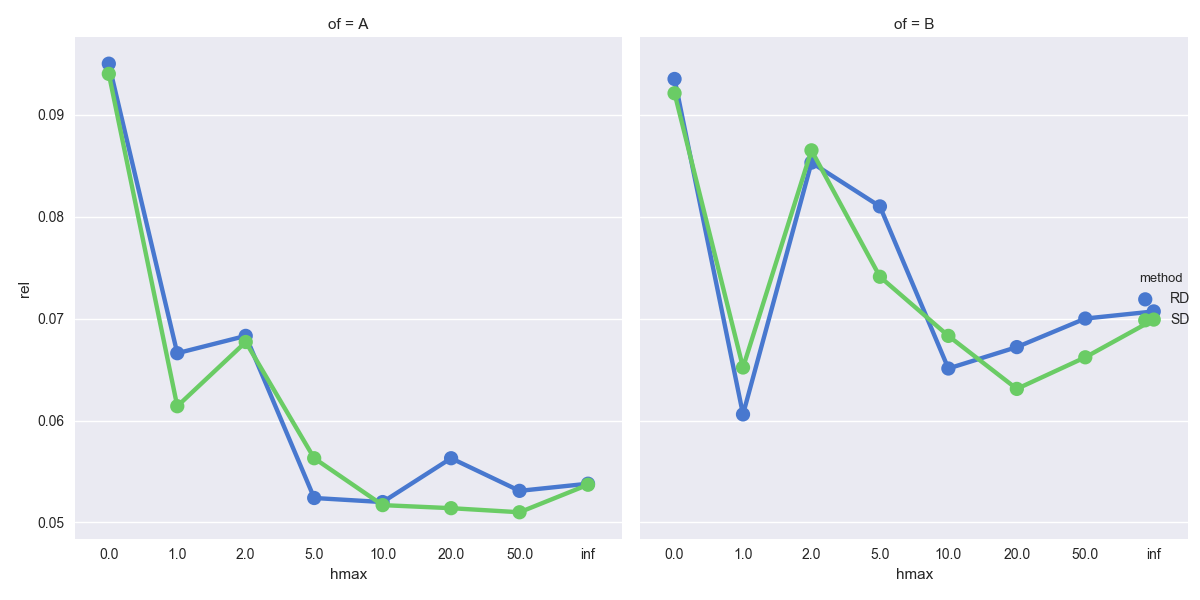

In [21]:
g = sns.FacetGrid(stats, col='of', size=6)
ax = g.map(sns.pointplot, 'hmax', 'rel','method', palette=sns.color_palette("muted")).add_legend(title='method')

#### Mean number of evaluations

<IPython.core.display.Javascript object>


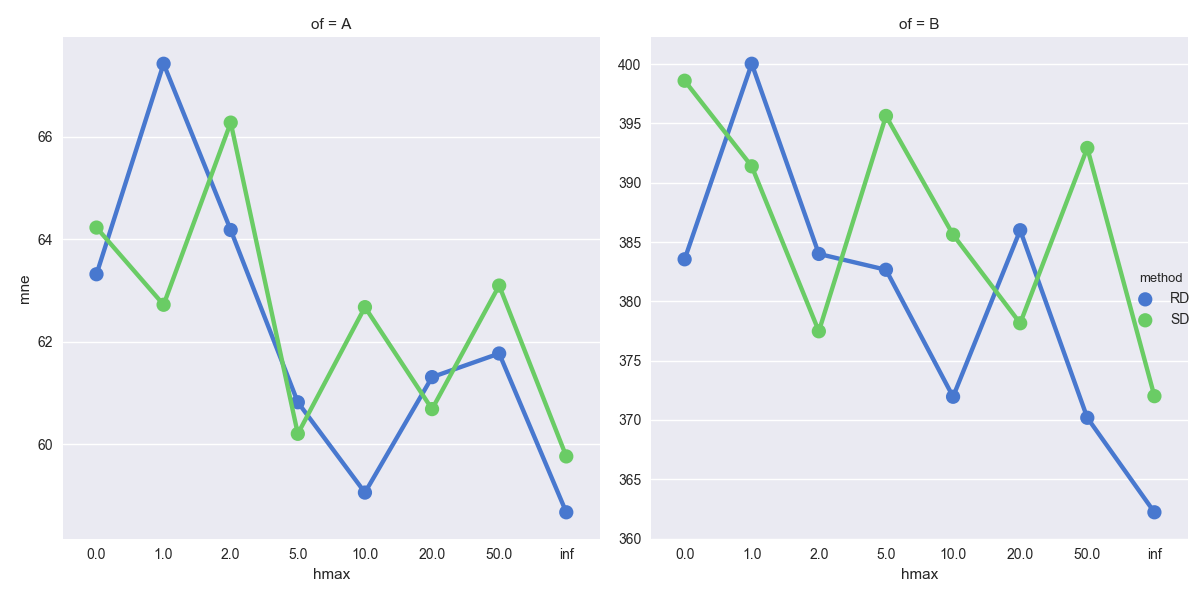

In [22]:
g = sns.FacetGrid(stats, col='of', sharey=False, size=6)
ax = g.map(sns.pointplot, 'hmax', 'mne','method', palette=sns.color_palette("muted")).add_legend(title='method')

#### Feoktistov criterion

<IPython.core.display.Javascript object>


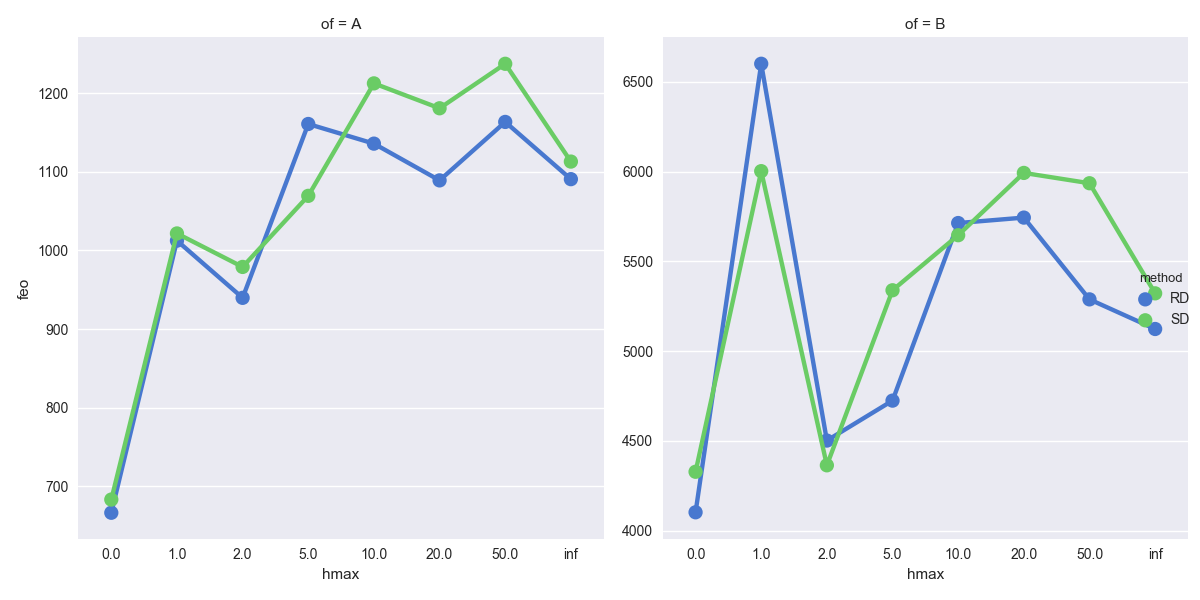

In [23]:
g = sns.FacetGrid(stats, col='of', sharey=False, size=6)
ax = g.map(sns.pointplot, 'hmax', 'feo','method', palette=sns.color_palette("muted")).add_legend(title='method')

## Conclusion

* Usually, it is not worth to spend unncessary time with exhaustive evaluation of local neighbourhoods in higher dimensions (and difficult multimodal objective functions).

## Assignment

* Investigate how many evaluations were made for some certain level $h$ of the local search phase of Shoot & Go heuristic. Evalute these statistics on both `Sum` and `SumSin` functions.